# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [1]:
import os
import pickle
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io
import scipy.stats
import seaborn as sns
from ipywidgets import interact
from scipy.stats import gaussian_kde
from tqdm import tqdm

sys.path.append(os.path.abspath("code"))

palette = sns.color_palette("tab10")
sns.set_theme(
    context="paper",        
    style="white",
    palette=palette,
    font="Times New Roman", 
    font_scale=1.5
)

### Exercise 1A

In [2]:
#### Simulation parameters ####
track_length = 200
average_firing_rate = 5
n_cells = 100
n_runs = 20
fps = 30

def get_true_firing_rate_maps(n_cells, track_length, avg_firing_rate, pf_size_scale=1.0):
    # Place field parameters
    pf_centers = np.random.rand(n_cells) * track_length
    pf_size = np.random.gamma(shape=10, size=n_cells) * pf_size_scale
    pf_rate = np.random.exponential(scale=avg_firing_rate, size=n_cells)
    pf_params = np.vstack((pf_centers, pf_size, pf_rate)).T
    
    # Generate place field firing rate maps
    bins = np.arange(0, track_length)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i] = pf_rate[i] * np.exp(-((bins - pf_centers[i])**2) / (2 * pf_size[i]**2))
        
    return true_firing_rate_maps, bins, pf_params

def simulate_env(n_runs, bins, fps):
    running_speed_a = np.random.chisquare(df=10, size=n_runs)
    running_speed_b = np.random.chisquare(df=10, size=n_runs)
    stopping_time_a = np.random.chisquare(df=15, size=n_runs)
    stopping_time_b = np.random.chisquare(df=15, size=n_runs)
    x = []
    for i in range(n_runs):
        stop1 = np.full(int(stopping_time_a[i] * fps), 0.)
        run1 = np.linspace(0., len(bins) - 1, int(len(bins) * fps / running_speed_a[i]))
        stop2 = np.full(int(stopping_time_b[i] * fps), len(bins) - 1.)
        run2 = np.linspace(len(bins) - 1, 0., int(len(bins) * fps / running_speed_b[i]))
        x.extend([*stop1, *run1, *stop2, *run2])
    x = np.array(x)
    t = np.arange(len(x)) / fps
    return x, t

def get_spike_train(t, x, true_firing_rate_maps, space_bins, noise_firing_rate=0.1):
    sampling_rate = 10000
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x)).astype(np.int32)
    spikes = []
    for i in tqdm(range(true_firing_rate_maps.shape[0]), desc="Simulating spikes"):
        inst_rate = true_firing_rate_maps[i, x_sampling] + noise_firing_rate
        spike_train = np.random.poisson(inst_rate / sampling_rate)
        spike_times = t_sampling[np.nonzero(spike_train)[0]]
        spikes.append(spike_times)
    spike_positions = [np.interp(s, t, x) for s in spikes]
    spikes_hist = [np.histogram(pos, space_bins)[0] for pos in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy
    return spikes, firing_rate_maps, occupancy

In [3]:
true_firing_rate_maps, bins, pf_params = get_true_firing_rate_maps(n_cells, track_length, average_firing_rate)
mouse_pos, time = simulate_env(n_runs, bins, fps)

Simulating spikes: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


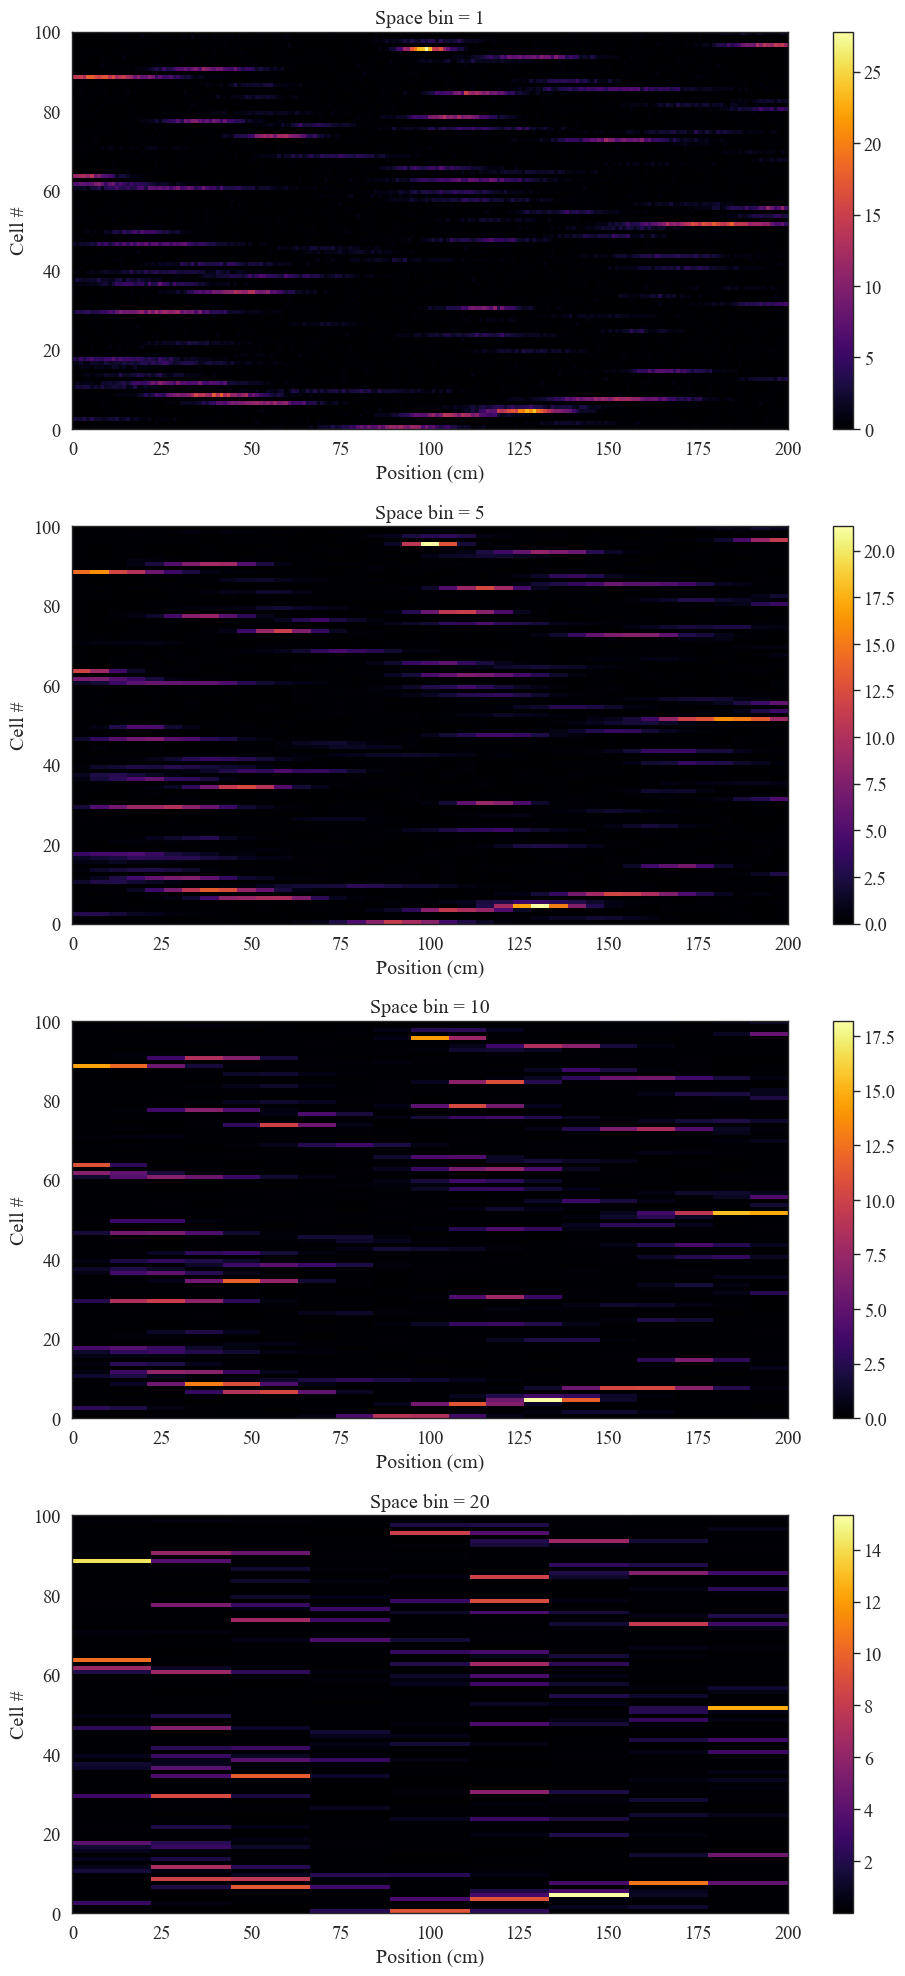

In [4]:
steps = [1, 5, 10, 20]
fig, axs = plt.subplots(len(steps), 1, figsize=(10, len(steps) * 5))
axs = axs.flatten()
for i, step in enumerate(steps):
    space_bins = np.arange(0, track_length, step)
    spikes, firing_rate_maps, _ = get_spike_train(time, mouse_pos, true_firing_rate_maps, space_bins)
    im = axs[i].imshow(firing_rate_maps, aspect='auto', cmap='inferno', extent=[0, track_length, 0, n_cells])
    axs[i].set_title(f'Space bin = {step}')
    axs[i].set_xlabel("Position (cm)")
    axs[i].set_ylabel("Cell #")
    cbar = fig.colorbar(im, ax=axs[i])
plt.tight_layout()
plt.show()

In the above plot, we can see that as the spatial bin size increases from 1 to 20 cm, the firing rate maps become progressively smoother and less spatially precise. Fine-grained features evident at bin size 1 are averaged out at larger bin sizes, reducing noise but also diminishing spatial resolution. This reflects a trade-off between spatial detail and signal stability: smaller bins capture more detailed firing patterns but may suffer from higher variability, while larger bins emphasize broader firing patterns at the cost of losing fine structure. Additionally, the firing rate of cells decrease with larger bins due to the averaging over larger spatial extents.

### Exercise 1B

Simulating spikes: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


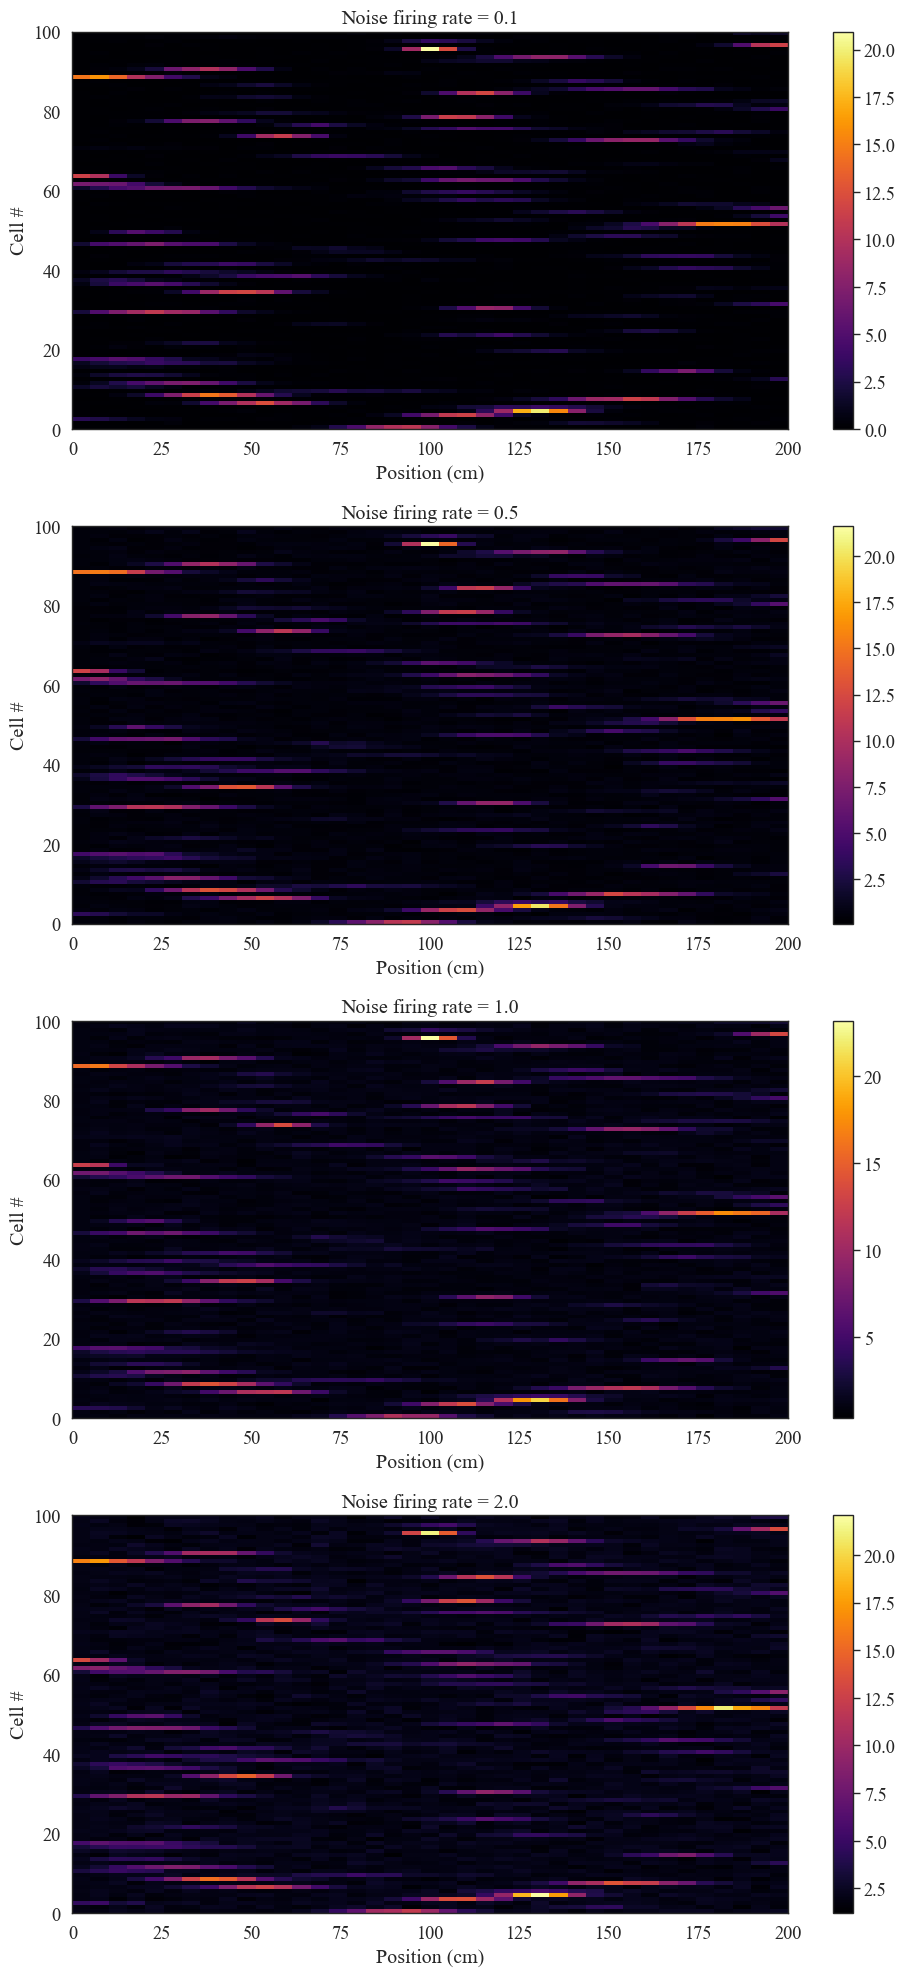

In [5]:
space_bins = np.arange(0, track_length, 5)
noise_firing_rates = [0.1, 0.5, 1.0, 2.0]
fig, axs = plt.subplots(len(noise_firing_rates), 1, figsize=(10, len(noise_firing_rates) * 5))
axs = axs.flatten()
for i, noise_firing_rate in enumerate(noise_firing_rates):
    spikes, firing_rate_maps, _ = get_spike_train(time, mouse_pos, true_firing_rate_maps, space_bins, noise_firing_rate)
    im = axs[i].imshow(firing_rate_maps, aspect='auto', cmap='inferno', extent=[0, track_length, 0, n_cells])
    axs[i].set_title(f'Noise firing rate = {noise_firing_rate}')
    axs[i].set_xlabel("Position (cm)")
    axs[i].set_ylabel("Cell #")
    cbar = fig.colorbar(im, ax=axs[i])
plt.tight_layout()
plt.show()

The variable that determines the noise level in the spike train simulations is **noise_firing_rate**. As shown in the plot, increasing the noise firing rate from 0.1 to 2.0 progressively masks the spatial selectivity of cells, which means that the contrast between place fields and background activity becomes less distinct. This leads to more uniform and less sparse firing rate maps, thus the signal-to-noise ratio is reduced.

To mitigate the effects of high noise, we can apply spatial smoothing or use coarser spatial bins, which reduces variability and enhances consistent spatial patterns. However, these methods come with trade-offs: too much smoothing or binning can destroy fine spatial tuning. Thus, the best approach could be combining moerate spatial smoothing with techniques like Gaussian smoothing kernels can help recover interpretable firing maps while minimizing false positives.

### Exercise 1C

Simulating spikes: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


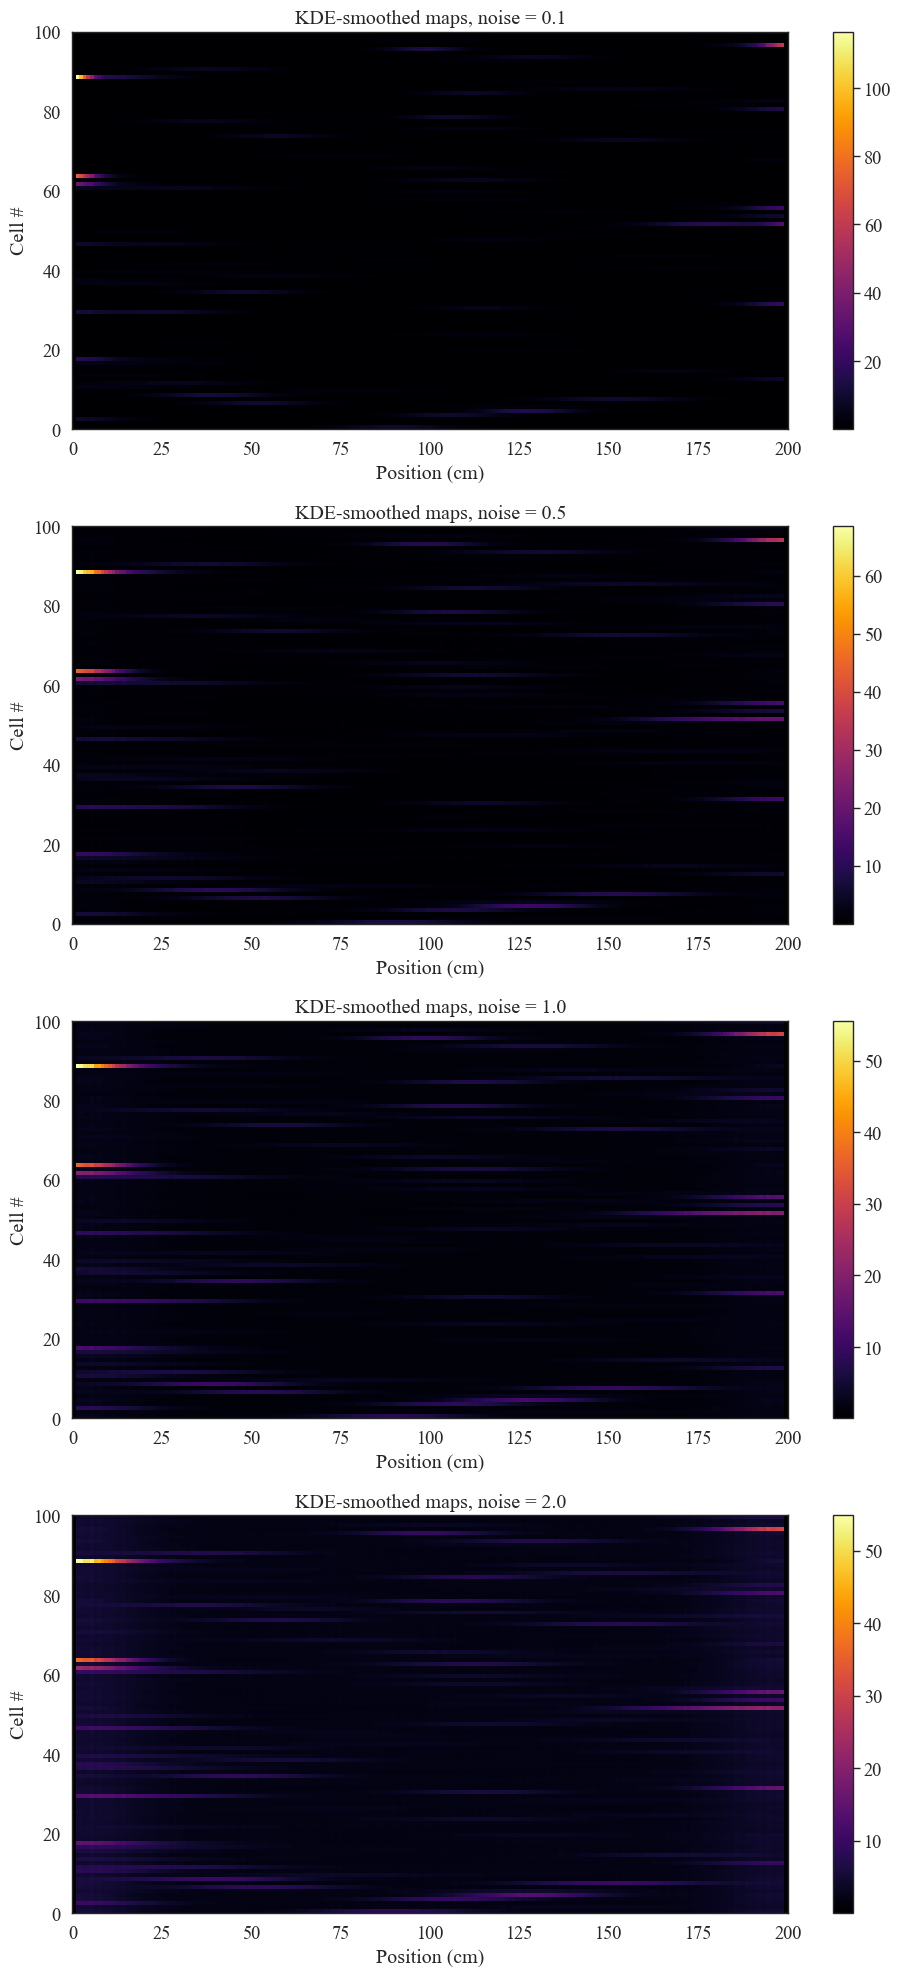

In [6]:
space_bins = np.arange(0, track_length)

def smooth_firing_rate_map(spikes, t, x, space_bins):
    spike_positions = [np.interp(s, t, x) for s in spikes]
    occupancy = np.histogram(x, space_bins)[0] / fps
    space_centers = (space_bins[:-1] + space_bins[1:]) / 2
    firing_rate_maps_kde = np.zeros((n_cells, len(space_centers)))
    for i, pos in enumerate(spike_positions):
        if len(pos) < 2:
            continue
        kde = gaussian_kde(pos)
        density = kde(space_centers)
        expected_counts = len(pos) * density
        firing_rate_maps_kde[i] = np.divide(
            expected_counts, occupancy, out=np.zeros_like(expected_counts), where=occupancy > 0
        )
    return firing_rate_maps_kde

fig, axs = plt.subplots(len(noise_firing_rates), 1, figsize=(10,  len(noise_firing_rates) * 5))
for idx, noise in enumerate(noise_firing_rates):
    spikes, _, _ = get_spike_train(time, mouse_pos, true_firing_rate_maps, space_bins, noise)
    firing_rate_maps_smooth = smooth_firing_rate_map(spikes, time, mouse_pos, space_bins)
    im = axs[idx].imshow(firing_rate_maps_smooth, aspect='auto', cmap='inferno', extent=[0, track_length, 0, n_cells])
    axs[idx].set_title(f'KDE-smoothed maps, noise = {noise}')
    axs[idx].set_xlabel('Position (cm)')
    axs[idx].set_ylabel('Cell #')
    fig.colorbar(im, ax=axs[idx])
plt.tight_layout()
plt.show()

Compared to raw firing rate maps, Gaussian smoothed firing rate maps enhance spatial continuity and reduce local variability, making place fields more visually distinct at low noise levels. As noise increases, however, smoothing spreads the noise uniformly across space, and blurs the contrast between place-related and random activity. At moderate noise levels, smoothed maps provide a good balance between denoising and retaining spatial features. But at high noise (e.g., 2.0), Gaussian smoothing tends to over-smooth, producing overly diffuse maps that destroy spatial tuning. Therefore, while smoothing improves interpretability when noise is low, raw or lightly smoothed rate maps may be more reliable under high noise conditions.

### Exercise 1D

Simulating spikes: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Mean absolute error: 14.52 cm
Root-mean-square error: 20.87 cm
Pearson correlation: 0.96


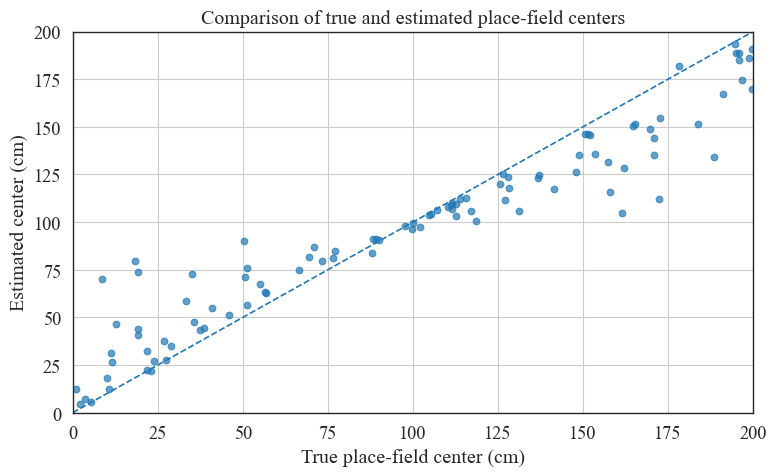

In [7]:
space_bins = np.arange(0, track_length)
spikes, _, _ = get_spike_train(time, mouse_pos, true_firing_rate_maps, space_bins)
spike_positions = [np.interp(s, time, mouse_pos) for s in spikes]

c_pf = np.array([pos.mean() if len(pos) else np.nan for pos in spike_positions])
c_pf = c_pf[~np.isnan(c_pf)]

pf_centers = pf_params[:, 0]
mae = np.mean(np.abs(c_pf - pf_centers))
rmse = np.sqrt(np.mean((c_pf - pf_centers) ** 2))
r = np.corrcoef(c_pf, pf_centers)[0, 1]

print(f"Mean absolute error: {mae:.2f} cm")
print(f"Root-mean-square error: {rmse:.2f} cm")
print(f"Pearson correlation: {r:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(pf_centers, c_pf, alpha=0.7)
plt.plot([0, track_length], [0, track_length], ls="--")
plt.xlabel("True place-field center (cm)")
plt.ylabel("Estimated center (cm)")
plt.title("Comparison of true and estimated place-field centers")
plt.xlim(0, track_length)
plt.ylim(0, track_length)
plt.grid()
plt.tight_layout()
plt.show()

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

### Exercise 2A

In [8]:
def get_spatial_information(firing_rate_map, occupancy, eps=1e-15):
    p_occ = occupancy / occupancy.sum()
    lambd = np.sum(firing_rate_map * p_occ)                         
    info = np.sum(firing_rate_map * np.log2((firing_rate_map + eps) / lambd) * p_occ)
    return info, info / lambd if lambd > 0 else np.nan

# Simulate place cells
space_bins = np.arange(0, track_length)
spikes, firing_rate_maps, occupancy = get_spike_train(time, mouse_pos, true_firing_rate_maps, space_bins)

# Compute spatial information
I = []
I_s = []
for fr in firing_rate_maps:
    info, info_spk = get_spatial_information(fr, occupancy)
    I.append(info)
    I_s.append(info_spk)
I = np.array(I)
I_s = np.array(I_s)

print("Mean spatial information:")
print(f"\tbits/s: {I.mean():.3f}")
print(f"\tbits/spike: {I_s.mean():.3f}")

Simulating spikes: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Mean spatial information:
	bits/s: 1.090
	bits/spike: 1.624


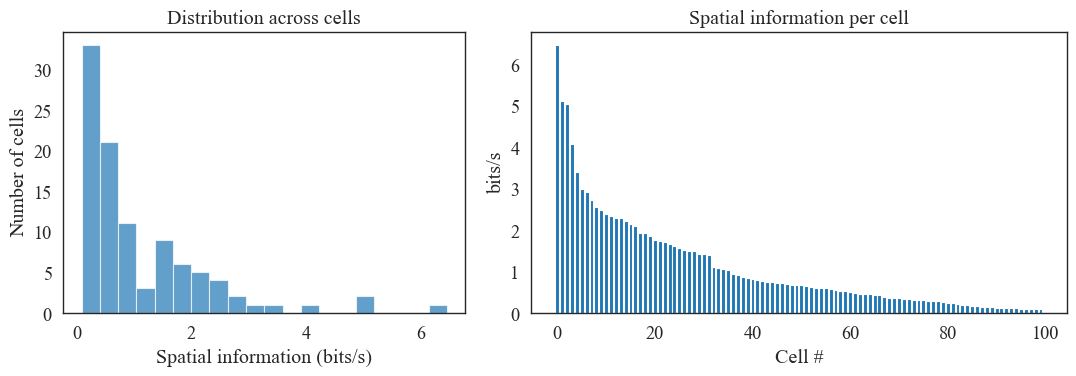

In [9]:
_, axs = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={'width_ratios': [1.5, 2]})

axs[0].hist(I, bins=20, alpha=0.7)
axs[0].set_xlabel("Spatial information (bits/s)")
axs[0].set_ylabel("Number of cells")
axs[0].set_title("Distribution across cells")

order = np.argsort(I)[::-1]
axs[1].bar(range(len(I)), I[order], color=palette[0])
axs[1].set_xlabel("Cell #")
axs[1].set_ylabel('bits/s')
axs[1].set_title('Spatial information per cell')

plt.tight_layout()
plt.show()

### Exercise 2B

In [10]:
def get_experimental_data(parameter_values, parameter_name):
    mi_bits_s = []
    mi_bits_spike = []

    # Set base parameters
    base_fr = 5
    base_size = 5
    base_noise = 0.1

    for val in parameter_values:
        # Set parameters for this iteration
        avg_fr = base_fr if parameter_name != "average_firing_rate" else val
        cell_size = base_size if parameter_name != "pf_size_scale" else val
        noise = base_noise if parameter_name != "noise_firing_rate" else val
        # Generate true firing rate maps
        true_fr_rate_maps, bins, _ = get_true_firing_rate_maps(n_cells, track_length, avg_fr, pf_size_scale=cell_size)
        # Simulate environment
        mouse_pos, time = simulate_env(n_runs, bins, fps)
        # Generate spike train
        spikes, fr_maps, occupancy = get_spike_train(time, mouse_pos, true_fr_rate_maps, bins, noise)
        # Compute spatial information
        info_s, info_spike = [], []
        for fr in fr_maps:
            i_s, i_spike = get_spatial_information(fr, occupancy)
            info_s.append(i_s)
            info_spike.append(i_spike)
        mi_bits_s.append(np.nanmean(info_s))
        mi_bits_spike.append(np.nanmean(info_spike))
    return np.array(mi_bits_s), np.array(mi_bits_spike)


# Parameters
peak_rates = np.arange(1, 50, 10)
size_scales = np.arange(1, 50, 10)
noise_levels = np.linspace(0.1, 3, 10)

# Get experimental data
mi_fr_bs, mi_fr_bspk = get_experimental_data(peak_rates, "average_firing_rate")
mi_size_bs, mi_size_bspk = get_experimental_data(size_scales, "pf_size_scale")
mi_noise_bs, mi_noise_bspk = get_experimental_data(noise_levels, "noise_firing_rate")

Simulating spikes: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


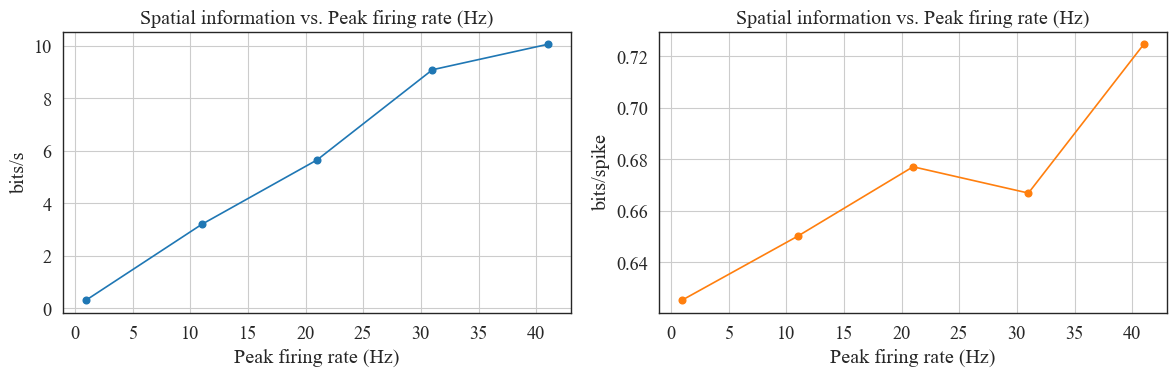

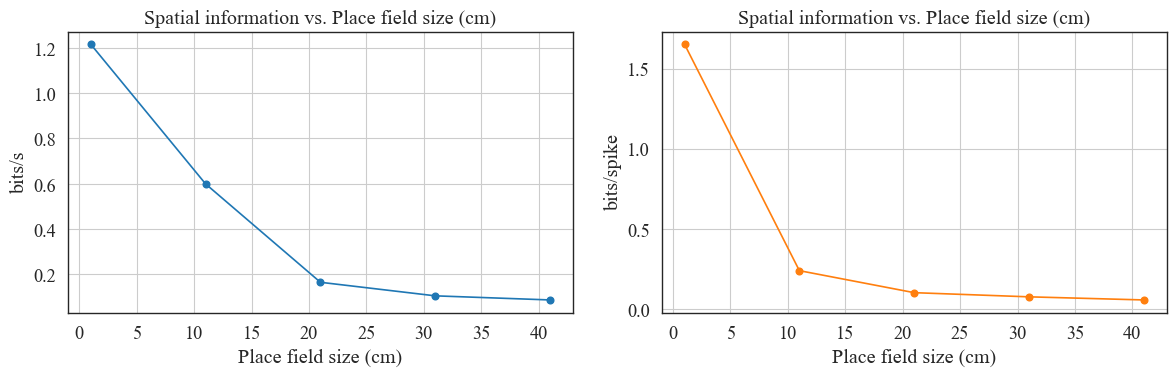

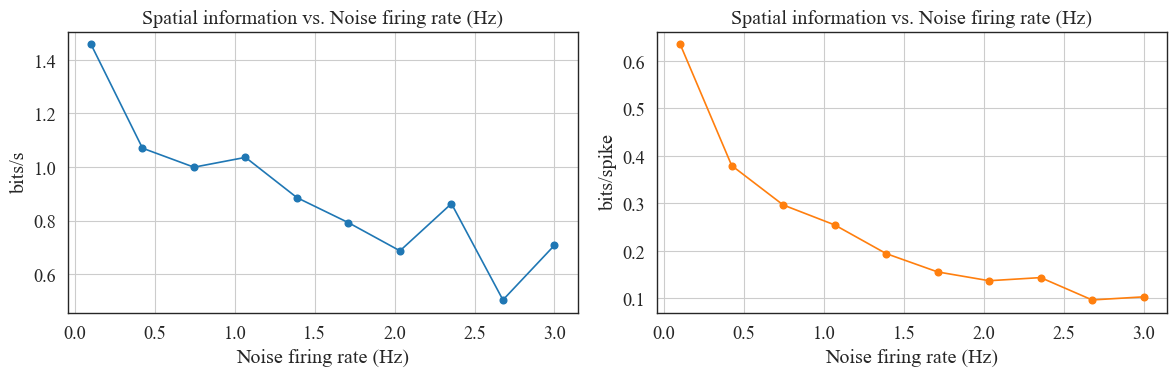

In [11]:
def plot_MI(x, y1, y2, xlabel):
    _, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Left: bits/s
    axs[0].plot(x, y1, marker="o", c="tab:blue", linestyle="-")
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel("bits/s")
    axs[0].set_title(f"Spatial information vs. {xlabel}")
    axs[0].grid()

    # Right: bits/spike
    axs[1].plot(x, y2, marker="o", c="tab:orange", linestyle="-")
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel("bits/spike")
    axs[1].set_title(f"Spatial information vs. {xlabel}")
    axs[1].grid()

    plt.tight_layout()
    plt.show()

plot_MI(peak_rates, mi_fr_bs, mi_fr_bspk, "Peak firing rate (Hz)")
plot_MI(size_scales, mi_size_bs, mi_size_bspk, "Place field size (cm)")
plot_MI(noise_levels, mi_noise_bs, mi_noise_bspk, "Noise firing rate (Hz)")

- Spatial information in bits/s increases steadily with peak firing rate, reflecting higher total information throughput. In contrast, bits/spike shows a more modest, non-linear increase, indicating that individual spikes do not become proportionally more informative at higher rates.

- Both bits/s and bits/spike decrease with increasing place field size, but bits/spike drops more sharply. This indicates that larger fields reduce not just the amount but also the efficiency of spatial information. The strong decline in bits/spike suggests that place specificity is critical for per spike efficiency, whereas bits/s retains some robustness due to accumulated spike count. This shows that bits/spike is better suited to evaluate spatial selectivity, while bits/s reflects how much total information is carried despite broader tuning.

- As noise firing rate increases, bits/spike decreases steadily and substantially, indicating that noise degrades the precision of spike-based encoding. Bits/s also declines but less predictably. This difference shows that bits/s can overestimate informativeness when spikes are abundant but noisy. Thus, under high-noise conditions, bits/spike provides a more sensitive measure of coding quality.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [12]:
# read pickle file
with open("data/linear_track_data.pickle", "rb") as f:
    data = pickle.load(f)
    x = data["x"]
    t = data["t"]
    spikes = data["spikes"]

### Exercise 3A

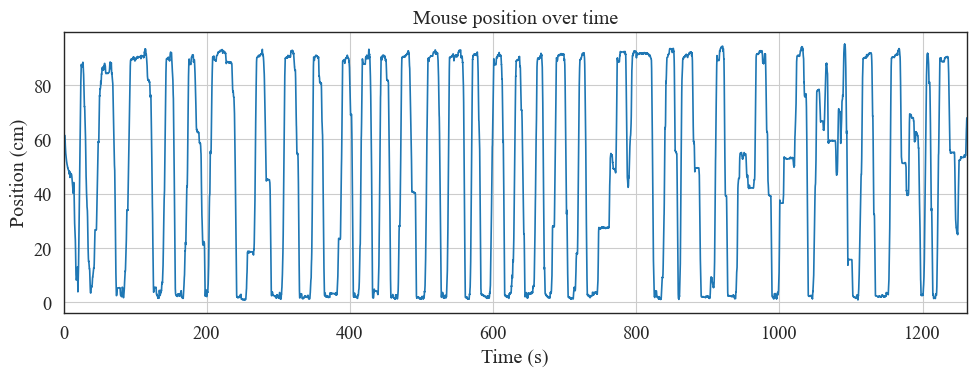

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(t, x)
plt.title("Mouse position over time")
plt.xlabel("Time (s)")
plt.ylabel("Position (cm)")
plt.xlim(0, t[-1])
plt.grid()
plt.tight_layout()
plt.show()

### Exercise 3B

In [14]:
track_min, track_max = np.floor(x.min()), np.ceil(x.max())
space_bins = np.arange(track_min, track_max)

dt = np.median(np.diff(t))
fps = 1. / dt
spike_positions = [np.interp(s, t, x) for s in spikes]
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.vstack(spikes_hist).astype(np.float64)
occupancy = np.histogram(x, space_bins)[0] / fps
firing_rate_maps = spikes_hist / occupancy

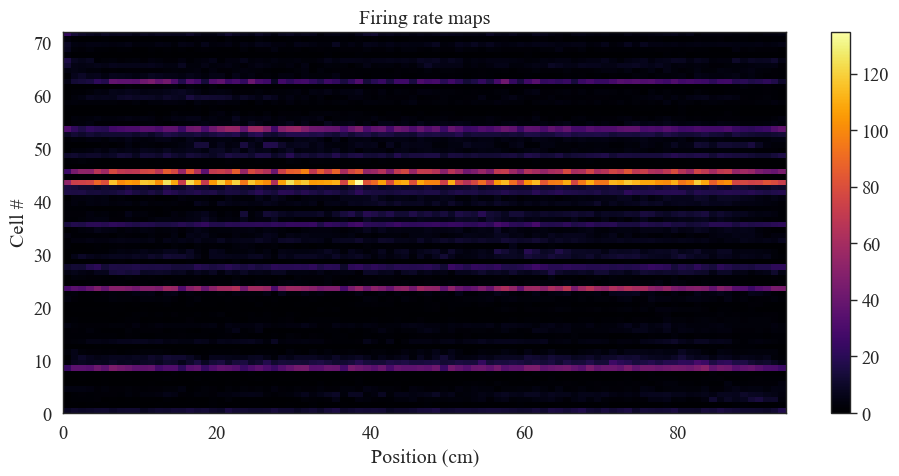

In [15]:
plt.figure(figsize=(10, 5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix, :], aspect='auto', cmap='inferno', extent=[space_bins[0], space_bins[-1], 0, len(spikes)])
plt.xlabel('Position (cm)')
plt.title('Firing rate maps')
plt.ylabel('Cell #')
plt.colorbar()
plt.tight_layout()
plt.show()

### Exercise 3C

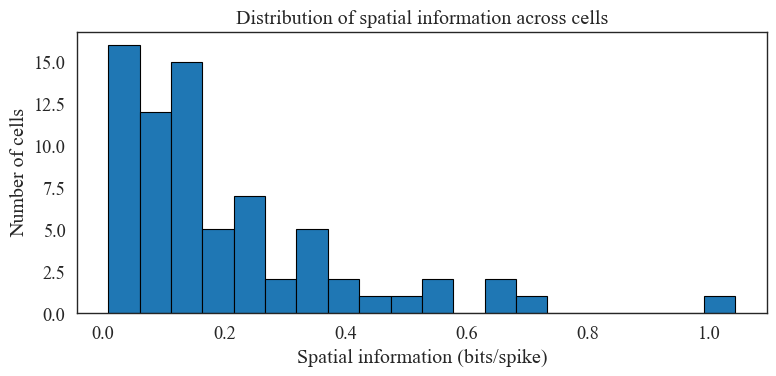

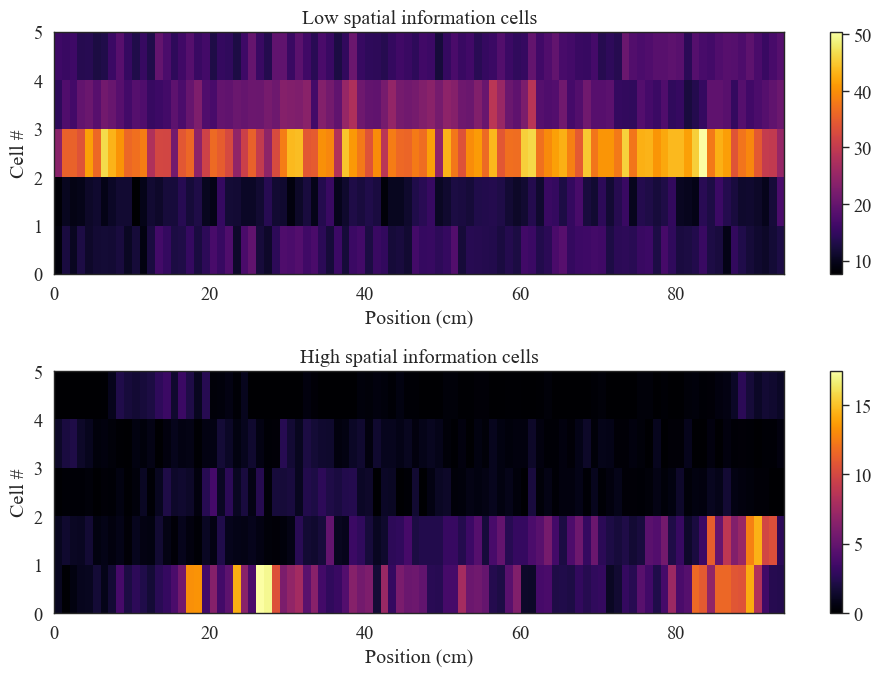

In [16]:
info_bits_spike = []
for i in range(firing_rate_maps.shape[0]):
    fr_rate_map = firing_rate_maps[i]
    _, info_spike = get_spatial_information(fr_rate_map, occupancy)
    info_bits_spike.append(info_spike)
info_bits_spike = np.array(info_bits_spike)

# Plot spatial information of each cell
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(info_bits_spike, bins=20, edgecolor="black")
ax.set_xlabel("Spatial information (bits/spike)")
ax.set_ylabel("Number of cells")
ax.set_title("Distribution of spatial information across cells")
fig.tight_layout()
plt.show()

# Select low and high spatial information cells
low_idx = np.argsort(info_bits_spike)[:5]
high_idx = np.argsort(info_bits_spike)[-5:][::-1]
low_firing_rate_maps = firing_rate_maps[low_idx]
high_firing_rate_maps = firing_rate_maps[high_idx]

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
# Firing rate maps of low spatial information cells
im0 = axs[0].imshow(low_firing_rate_maps, aspect='auto', cmap='inferno', 
                    extent=[space_bins[0], space_bins[-1], 0, len(low_firing_rate_maps)])
axs[0].set_title("Low spatial information cells")
axs[0].set_ylabel("Cell #")
axs[0].set_xlabel("Position (cm)")
cbar0 = fig.colorbar(im0, ax=axs[0])

# Firing rate maps of high spatial information cells
im1 = axs[1].imshow(high_firing_rate_maps, aspect='auto', cmap='inferno',
                    extent=[space_bins[0], space_bins[-1], 0, len(high_firing_rate_maps)])
axs[1].set_title("High spatial information cells")
axs[1].set_ylabel("Cell #")
axs[1].set_xlabel("Position (cm)")
cbar1 = fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In the above firing rate map comparison, we can see that low spatial information cells firing maps show widespread, non-selective firing across the entire spatial environment. Their activity is relatively uniform, with little spatial modulation, suggesting weak spatial tuning and low informativeness per spike. These cells likely contribute more to background or noise-like activity.

On the other hand, high spatial information cells maps exhibit sparse and spatially limited firing fields. They show strong, localized peaks in firing, with minimal activity elsewhere, reflecting high spatial specificity. This kind of selective activity is characteristic of place cells, which are crucial for encoding spatial location.